In [2]:
# first time check
# ! module list
# pip install pyarrow #pip install pyarrow


Currently Loaded Modules:
  1) StdEnv       6) libspatialindex/1.9.3  11) sqlite/3.35.5
  2) gcc/8.2.0    7) netcdf/4.6.3           12) r/4.0.2
  3) gdal/3.4.3   8) eccodes/2.22.1         13) openblas/0.2.20
  4) geos/3.9.1   9) zlib/1.2.9             14) python/3.9.9
  5) proj/8.2.1  10) libtiff/4.2.0          15) eth_proxy

 

>

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
#import mplotutils as mpu
import geopandas as gpd
import sys
import os
import glob
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import climada.util.coordinates as u_coords
import pickle
#os.chdir('/cluster/project/climate/evelynm/climada_petals/climada_petals/engine/networks') 
from climada_petals.engine.networks import nw_utils as nwu
os.chdir('/cluster/project/climate/evelynm/mplotutils') 
import mplotutils as mpu

In [58]:
###########
# Color definitions
###########

class InfraColorMaps:
    def __init__(self):
        self.service_col_dict = {-1. : '#FF5733', 0. : 'grey', 1. : 'green'}
        self.service_col_map = ListedColormap(['#FF5733', 'grey', 'green'])
        self.servicecum_col_dict = {-9. : '#581845', -8. : '#581845',
                                -7. : '#581845', -6. : '#581845',  
                                -5. : '#581845', -4. : '#581845',
                                -3. : '#900C3F', -2. : '#C70039', 
                                -1. : '#FF5733', 0. : 'grey', 
                                 1. : 'green'}
        self.servicecum_col_map = ListedColormap(['#581845',  '#581845',
                                '#581845',  '#581845',  '#581845', '#581845',
                               '#900C3F', '#C70039',  '#FF5733', 'grey', 'green'])
        self.casc_col_dict = {0. : 'blue', 1. : 'magenta', 2. : 'yellow'}
        self.casc_col_map = ListedColormap(['blue','magenta','yellow'])

def _two_slope_norm(vmin=-10, vcenter=0, vmax=1):
    """
    Two Slope Norm example from
    https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    """
    #cols_access = plt.cm.Greens(np.linspace(0.75, 1, 25))
    cols_access = plt.cm.Greens(np.linspace(0.2, 0.3, 10))
    cols_inavail = plt.cm.Greys(np.linspace(0.2, 0.3, 11))
    cols_disrupt = plt.cm.magma(np.linspace(0, 0.75, 20))
    all_colors = np.vstack((cols_disrupt, cols_inavail, cols_access))
    segment_colmap = colors.LinearSegmentedColormap.from_list('service_states', all_colors)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    return segment_colmap, divnorm      
        


In [41]:
###########
# Helper funcs
###########

def service_dict():
    return {'power_line' : 'electricity',
           'celltower' : 'mobile communications',
           'health': 'healthcare facilities',
           'education' : 'educational facility',
           'road' : 'roads'}


def _get_extent(gdf):
    buffer_deg = 0.1
    sub_gdf = gdf[gdf.geometry.type == 'Point']
    return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                     min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)

def _get_roadmask(gdf):
    """
    don't plot road access links which were generated during network construction
    in road plots
    """
    access_links = 0
    for ci_type in ['health', 'education', 'people']:
        access_links+=sum(gdf.ci_type==ci_type)
    return sum(gdf.ci_type=='road')-int(access_links*2)

                  
def get_cascstate(gdf):
    casc_state = [0]* len(gdf)
    for i in range(len(gdf)):
        if ((gdf.func_tot.iloc[i]==0) & (gdf.func_internal.iloc[i]==0)):
            casc_state[i] = 1
        elif ((gdf.func_tot.iloc[i] ==0) & (gdf.func_internal.iloc[i] >0)):
            casc_state[i] = 2
    return casc_state                                   

def get_accessstates(gdf, node_gdf_orig):
    """
    1 - accessible, 0 - inaccessible from beginning on, -1 - disrupted due to 
    disaster
    
    Changes gdf entries.
    """
    
    services = [colname for colname in gdf.columns if 'actual_supply_' in colname] 
    for service in services:
        serv_level = gdf[gdf.ci_type=='people'][service].values
        serv_level_orig = node_gdf_orig[node_gdf_orig.ci_type=='people'][service].values
        serv_level[(serv_level==0.) & (serv_level_orig==1.)]= -1.
        gdf.loc[gdf.ci_type=='people', service] = serv_level
    return gdf

In [4]:
###########
# Analysis Functions
###########

In [5]:
def sum_impacts(gdf_list):
    services = [colname for colname in gdf_list[0].columns if 'actual_supply_' in colname]
    gdf_services = gdf_list[0][gdf_list[0].ci_type=='people'][['counts', 'geometry']]
    
    for service in services:
        service_counts = np.array(gdf_list[0][gdf_list[0].ci_type=='people'][service].values)
        for gdf in gdf_list[1:]:
            service_counts = np.vstack([service_counts, np.array(gdf[gdf.ci_type=='people'][service].values)])
        failures = np.ma.masked_greater_equal(service_counts, 0).sum(axis=0).filled(np.nan)
        inavails = np.ma.masked_not_equal(service_counts, 0).sum(axis=0).filled(np.nan)
        failures[~np.isnan(inavails)] = 0.
        failures[np.isnan(failures)] = 1.
        gdf_services[service] = failures
        
    return gdf_services

def cumulative_affected_pop(gdf_cumimpacts):
    services = [colname for colname in gdf_cumimpacts.columns if 'actual_supply_' in colname]
    

In [6]:
###########
# Plotting Functions
###########

In [7]:
def infra_plot(gdf, save_path=None):
    """ all infrastructures in one plot"""
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                          subplot_kw=dict(projection=ccrs.PlateCarree()),
                          figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='road':
            gdf[gdf.ci_type==ci_type][:_get_roadmask(gdf)
                    ].plot(ax=ax, markersize=1, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), color='k')
        else:
            gdf[gdf.ci_type==ci_type].plot(
                ax=ax, markersize=1, linewidth=0.5, 
                transform=ccrs.PlateCarree(), color='k')
            
        ax.set_title(f'{ci_type}', weight='bold', fontsize=17)
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    f.suptitle('Infrastructures', weight='bold', fontsize=24)
    f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)   
    
    if save_path:
        plt.savefig(f'{save_path}'+'infrastructures.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        

In [47]:
def infra_func_plot(gdf, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of functional, destroyed-dysfunctional, 
    cascaded-dysfunctional
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        if ci_type=='road':
            # gdf[gdf.ci_type==ci_type][:_get_roadmask(gdf)] if avoiding ppl-road connections
            gdf[gdf.ci_type==ci_type].plot(ax=ax, markersize=0, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                           color=gdf[gdf.ci_type==ci_type].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist())
        elif ci_type=='power_line':
            gdf[gdf.ci_type==ci_type].plot(ax=ax, markersize=1, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                           color=gdf[gdf.ci_type==ci_type].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist())
        else:
            h_casc = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                                gdf[gdf.ci_type==ci_type].geometry.y, 
                                c=gdf[gdf.ci_type==ci_type].casc_state,
                                cmap=InfraColorMaps().casc_col_map, 
                                transform=ccrs.PlateCarree(), 
                                s=1.5, vmin=0, vmax=2)
            
        ax.set_title(f'Functional Failures {ci_type}', weight='bold', fontsize=17)
    
    cbar = mpu.colorbar(
        h_casc, axes.flatten()[-2], size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([0.33, 1., 1.66])
    cbar.set_ticklabels(['Func.', 'Dysfunc.', 'Casc.'])
    
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    f.suptitle(f'Failure states from event {event_name}', weight='bold', fontsize=24)
    #f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)  
    
    if save_path:
        plt.savefig(f'{save_path}'+f'failure_states_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        

In [45]:
def infra_impact_plot(gdf, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of structural damages
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people'})
    
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='power_line':
            gdf[gdf.ci_type==ci_type].plot('imp_dir', ax=ax, markersize=1, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=300.)
        elif ci_type=='road':
            gdf[gdf.ci_type==ci_type].plot('imp_dir', ax=ax, markersize=0, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=300.)
            # don't plot pple-road connections - works only if all people connected to road
            #gdf[gdf.ci_type==ci_type][
            #    :(len(gdf[gdf.ci_type=='road'])-len(gdf[gdf.ci_type=='people'])*2)
            #    ].plot('imp_dir', ax=ax, markersize=1, linewidth=0.5, 
            #           transform=ccrs.PlateCarree(), vmin=0., vmax=300.)
        else:
            h_imp = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                               gdf[gdf.ci_type==ci_type].geometry.y, 
                        c=gdf[gdf.ci_type==ci_type].imp_dir,
                        transform=ccrs.PlateCarree(), s=1.5, vmin=0., vmax=1.)
        ax.set_title(f'Structural damages {ci_type}', weight='bold', fontsize=17)

    cbar = mpu.colorbar(h_imp, axes.flatten()[-2], size=0.05, pad=0.15, 
                        orientation='horizontal')
    cbar.set_label('Structural Damage Frac.')
    f.suptitle(f'{event_name}', fontsize=24)
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
        
    if save_path:
        plt.savefig(f'{save_path}'+f'structural_impacts_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [52]:
def service_cumimpact_plot(gdf_cumimpacts, save_path=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    services = [colname for colname in gdf_cumimpacts.columns if 'actual_supply_' in colname] 
    #ci_types = set(gdf_cumimpacts.ci_type).difference({'people'})
    f, axes = plt.subplots(3, int(np.ceil(len(services)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,16))

    for service, ax in zip(services, axes.flatten()[:len(services)]):
        ax.set_extent(_get_extent(gdf_cumimpacts), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        vmin = np.min(gdf_cumimpacts.iloc[:,2:].values)
        segment_map, divnorm = _two_slope_norm(vmin=vmin, vcenter=0, vmax=1)
        pcm = ax.scatter(gdf_cumimpacts.geometry.x, 
                         gdf_cumimpacts.geometry.y, 
                         c=gdf_cumimpacts[service], norm=divnorm,
                         cmap=segment_map, transform=ccrs.PlateCarree(),
                         s=0.05)
        ax.set_title(f'Cumulative disr`s in access to {service}',
                     weight='bold', fontsize=15)
        cb = f.colorbar(pcm, shrink=0.6, ax=ax)
        tick_list = list(np.arange(vmin,0,5))
        tick_list.extend([0, 1])
        cb.set_ticks(tick_list)
        #plt.show()
        ax.set_title(f'Disruptions in access to {service_dict()[service[14:-7]]}', 
                     weight='bold', fontsize=12)   
        
    if len(services)%2>0:
        f.delaxes(axes[2,-1])
    f.subplots_adjust(bottom=0.05, top=0.95)  
                            
    if save_path:
        plt.savefig(f'{save_path}'+'service_disruptions_cum.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [11]:
        
def service_impact_plot(gdf, save_path=None, event_name=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    services = [colname for colname in gdf.columns if 'actual_supply_' in colname] 
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20*1.4142))

    for service, ax in zip(services, axes.flatten()[:len(services)]):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        h_serv = ax.scatter(gdf[gdf.ci_type=='people'].geometry.x, 
                            gdf[gdf.ci_type=='people'].geometry.y, 
                            c=gdf[gdf.ci_type=='people'][service],
                            cmap=InfraColorMaps().service_col_map, 
                            transform=ccrs.PlateCarree(), 
                            vmin=-1., vmax=1., s=0.1)
        ax.set_title(f'Disruptions in access to {service[14:-7]}', 
                     weight='bold', fontsize=17)         
                
    cbar = mpu.colorbar(
        h_serv, axes.flatten()[-2], size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([-0.66, 0., .66])
    cbar.set_ticklabels(['Disr.', 'Inavail.', 'Avail.'])
    
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    
    f.suptitle(f'Service Disruptions from event {event_name}', weight='bold', fontsize=24)
    #f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)  
                                       
    if save_path:
        plt.savefig(f'{save_path}'+f'service_disruptions_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [12]:
# =============================================================================
# Execution
# =============================================================================

### Mozambique - TC wind impacts 

In [13]:
PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'

In [14]:
cntry = 'Mozambique'
iso3 = u_coords.country_to_iso(cntry)

In [55]:
haz_type = 'TC' # or FL or EQ
path_cntry_folder = PATH_ROOT+f'{iso3}/'
path_save_plots = path_cntry_folder+'plots/'
if not os.path.isdir(path_save_plots):
    os.mkdir(path_save_plots)
path_nodes = path_cntry_folder+'cis_nw_nodes'
path_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
path_base_stats = path_cntry_folder+f'base_stats_{iso3}.pkl'

In [16]:
# get all result dataframes filepaths
if haz_type == 'TC':
    paths_result_files = [file for file in glob.glob(path_cntry_folder + 'cascade_results*') if not 'DFO' in file]
elif haz_type == 'FL':
    paths_result_files = glob.glob(path_cntry_folder + 'cascade_results_DFO*')
paths_result_files

['/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2002364S16045',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2007043S11071',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2019063S18038',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2012018S16041',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_1998016S12043',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2019112S10053',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2002307S07070',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_1996001S08075',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2003056S21042',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_2017043S19040',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_1995064S13042',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/cascade_results_1999357S08076',
 '/cluster/work/climate/evelynm/nw_outputs/MOZ/casca

In [17]:
# load node gdf
node_gdf_orig = gpd.read_feather(path_nodes)

In [56]:
# load stats dict
with open(path_stats, 'rb') as stats_dict:
     stats_dict = pickle.load(stats_dict)
# load base stats dict (pple without access to services)
with open(path_base_stats, 'rb') as base_stats_dict:
     base_stats_dict = pickle.load(base_stats_dict)

In [57]:
base_stats_dict

{'power': 5866038.157979012,
 'healthcare': 10801551.96877861,
 'education': 16574733.88212204,
 'telecom': 5663619.064863205,
 'mobility': 9598570.220466614}

In [19]:
# read in all result gdfs
gdf_list= []
for file_path in paths_result_files:
    gdf_list.append(gpd.read_feather(file_path))    

In [20]:
# get servcie access states and cascaded failure states for all gdfs
for i, gdf in enumerate(gdf_list):
    gdf_list[i] = get_accessstates(gdf, node_gdf_orig)
    gdf_list[i]['casc_state'] = get_cascstate(gdf)

In [21]:
gdf_cumimpacts = sum_impacts(gdf_list)

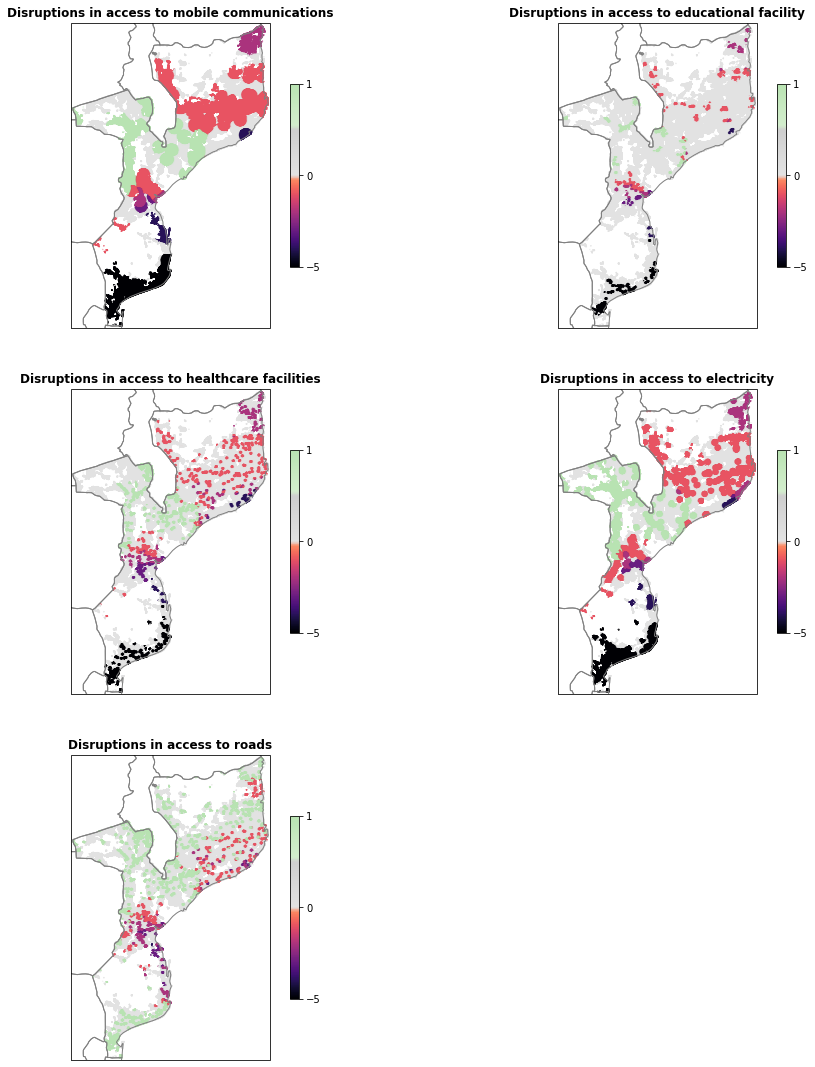

In [59]:
service_cumimpact_plot(gdf_cumimpacts, save_path=path_save_plots)

In [30]:
gdf_idai = gdf_list[2]
service_disr_idai = stats_dict['2019063S18038']

In [60]:
service_disr_idai

{'power': 7486458.241137505,
 'healthcare': 7260965.422168732,
 'education': 6624689.909017563,
 'telecom': 7716988.266508102,
 'mobility': 1533171.5915231705}

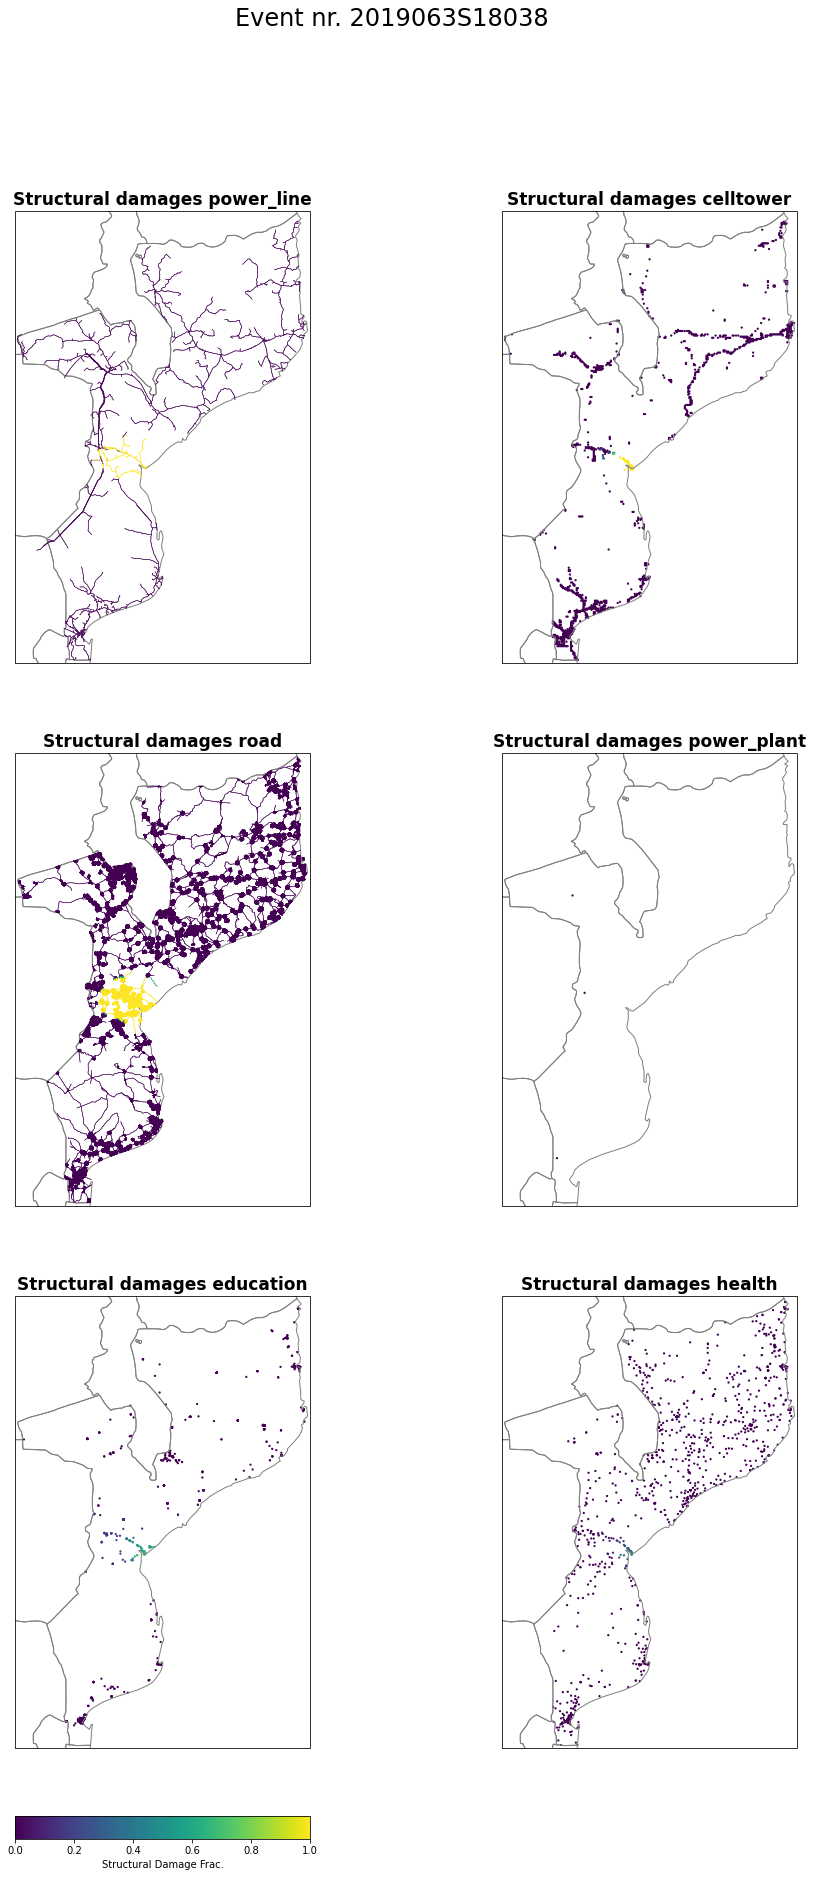

In [46]:
infra_impact_plot(gdf_idai, event_name='2019063S18038', save_path=path_save_plots)

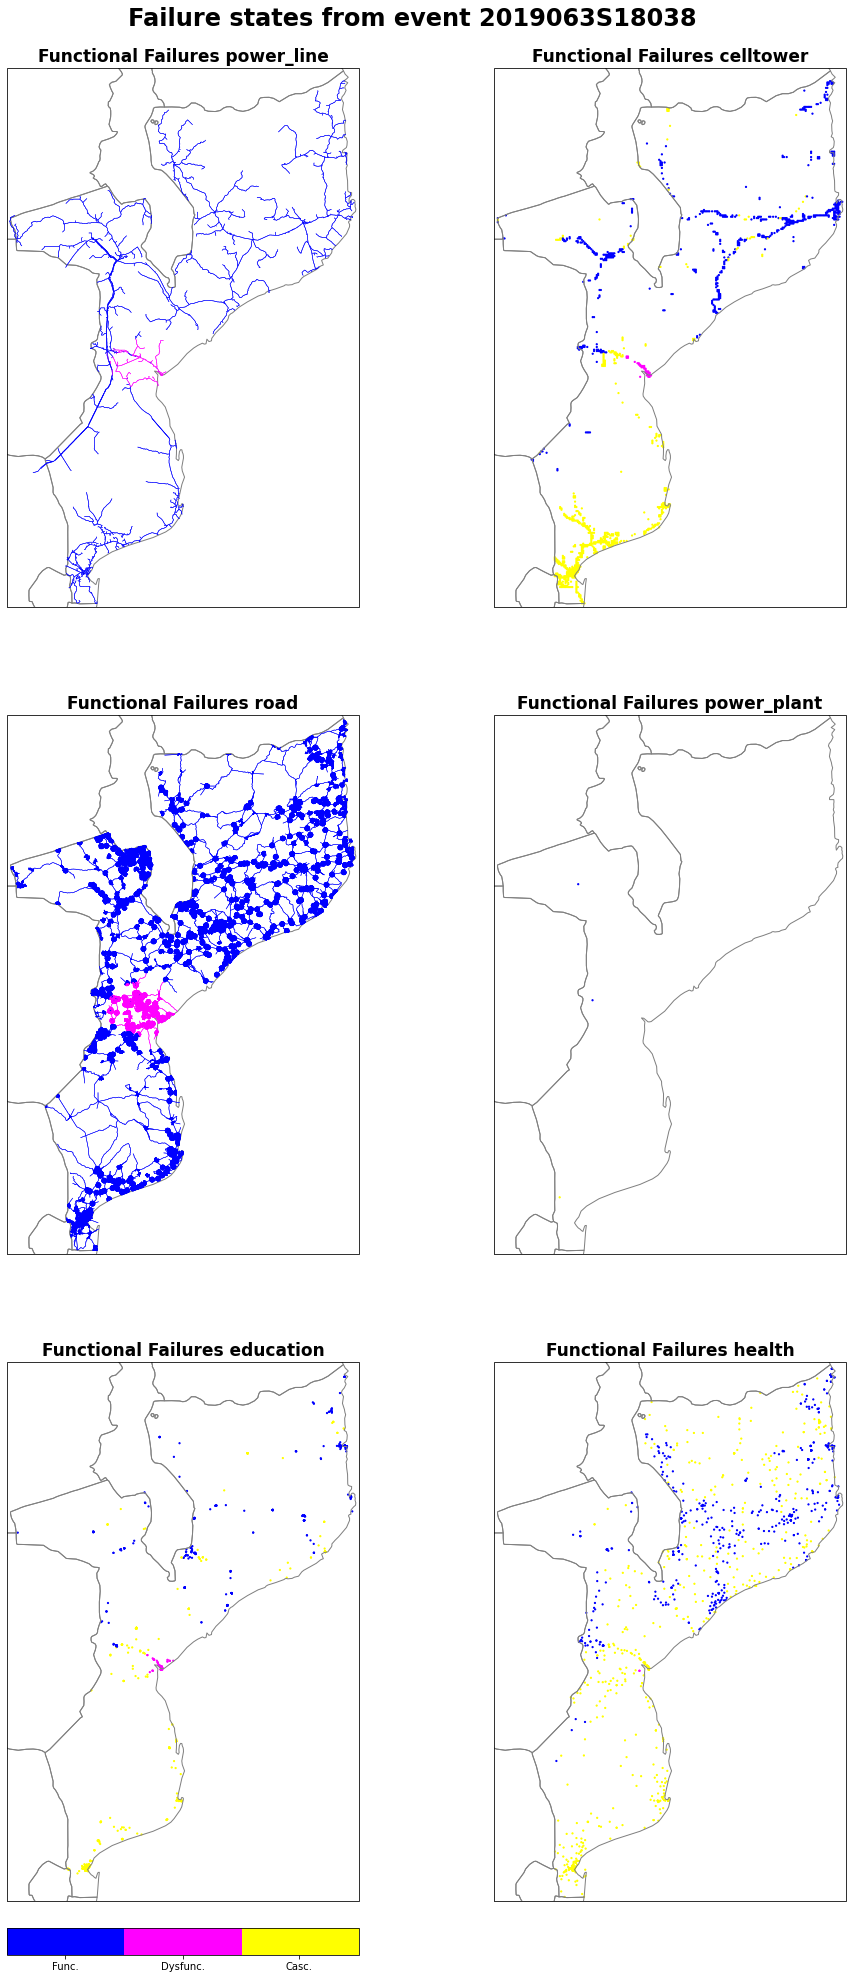

In [48]:
infra_func_plot(gdf_idai, event_name='2019063S18038', save_path=path_save_plots)

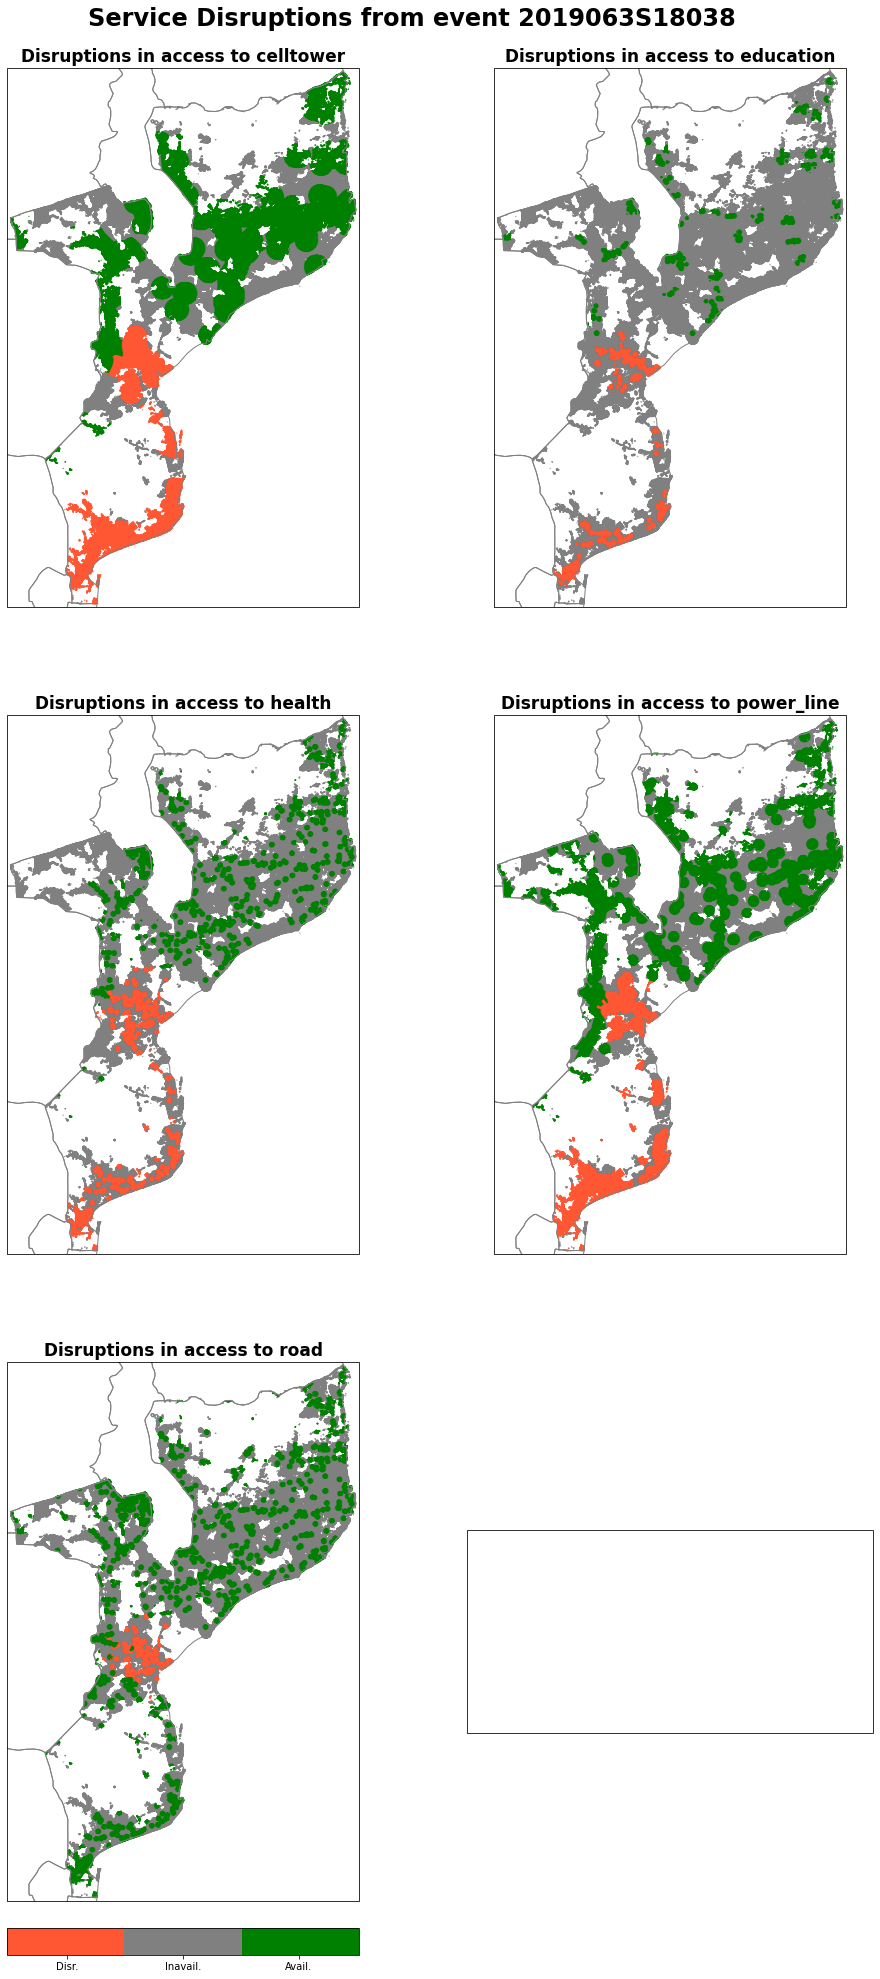

In [49]:
service_impact_plot(gdf_idai, event_name='2019063S18038', save_path=path_save_plots)

In [ ]:
# checking results
for i, gdf in enumerate(gdf_list):   
    services = [colname for colname in gdf.columns if 'actual_supply_' in colname]
    event_name = file_paths[i][-8:]
    for service in services:
        serv_level = gdf_list[i][gdf_list[i].ci_type=='people'][service].values
        print(event_name, service, np.unique(serv_level))

service_impact_plot(gdf_list[i], save_path=None, event_name=file_paths[i][-8:]) 
infra_func_plot(gdf_list[i], event_name=file_paths[i][-8:])
infra_impact_plot(gdf_list[i], file_paths[i][-8:])
    
